In [1]:
!nvidia-smi

Tue Oct  1 23:33:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070        On  |   00000000:07:00.0  On |                  N/A |
| 38%   44C    P0             50W /  220W |    1627MiB /   8192MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

2024-10-01 23:33:46.655900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 23:33:46.740788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 23:33:46.765799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 23:33:46.929820: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 23:33:48.126680: W tensorflow/compiler/tf2

In [3]:
images_dir = 'raw_images/'
train_dir = 'data/train/'
test_dir = 'data/validation/'

img_width, img_height = 224, 224
batch_size = 32
num_classes = 39  # Número de classes no seu dataset
epochs = 100
test_size=0.25

In [4]:
import os
import shutil
from sklearn.model_selection import StratifiedShuffleSplit

# Criar uma lista com os caminhos das imagens e suas respectivas classes
image_paths = []
labels = []
for class_folder in os.listdir(images_dir):
    class_path = os.path.join(images_dir, class_folder)
    if os.path.isdir(class_path):
        for image in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, image))
            labels.append(class_folder)

# Dividir os dados de forma estratificada
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
for train_index, test_index in sss.split(image_paths, labels):
    X_train = [image_paths[i] for i in train_index]
    X_test = [image_paths[i] for i in test_index]
    y_train = [labels[i] for i in train_index]
    y_test = [labels[i] for i in test_index]

# Copiar as imagens para os diretórios de treino e teste
for x, y in zip(X_train, y_train):
    dest = os.path.join(train_dir, y)
    if not os.path.exists(dest):
        os.makedirs(dest)
    shutil.copy(x, dest)

for x, y in zip(X_test, y_test):
    dest = os.path.join(test_dir, y)
    if not os.path.exists(dest):
        os.makedirs(dest)
    shutil.copy(x, dest)

In [5]:
# Criação do gerador de dados para o treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Criação do gerador de dados para a validação (sem augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 41586 images belonging to 39 classes.
Found 13862 images belonging to 39 classes.


In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    # ... adicione mais camadas conforme necessário
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            metrics=['accuracy'])

/home/gustavo/IC_HORTA_IOT_FIAP_2024/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1727836455.090449    1039 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727836455.313308    1039 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727836455.313368    1039 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727836455.315949

In [7]:
from PIL import Image
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/100


/home/gustavo/IC_HORTA_IOT_FIAP_2024/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727836458.844629    1385 service.cc:146] XLA service 0x7ff610005ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727836458.844669    1385 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-10-01 23:34:18.871520: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-01 23:34:18.984317: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version

   1/1299 ━━━━━━━━━━━━━━━━━━━━ 1:53:34 5s/step - accuracy: 0.0000e+00 - loss: 3.6871

I0000 00:00:1727836461.904647    1385 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 232s 175ms/step - accuracy: 0.2070 - loss: 3.1297 - val_accuracy: 0.3587 - val_loss: 2.5273
Epoch 2/100
   1/1299 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.2812 - loss: 2.6076

2024-10-01 23:38:08.806359: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-01 23:38:08.806405: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-01 23:38:08.806419: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-01 23:38:08.806445: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, trace

1299/1299 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.2812 - loss: 2.6076 - val_accuracy: 0.5000 - val_loss: 1.6571
Epoch 3/100


2024-10-01 23:38:09.725798: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-01 23:38:09.725846: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-01 23:38:09.725876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-01 23:38:31.396924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:39 169ms/step - accuracy: 0.3828 - loss: 2.4398

2024-10-01 23:38:11.101335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 223s 171ms/step - accuracy: 0.3528 - loss: 2.5199 - val_accuracy: 0.4086 - val_loss: 2.2986
Epoch 4/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.3750 - loss: 2.2631 - val_accuracy: 0.3333 - val_loss: 1.5292
Epoch 5/100


2024-10-01 23:41:53.039601: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-01 23:41:53.039660: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-01 23:41:53.045205: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-01 23:41:53.045240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-01 23:41:53.045270: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-01 23:42:14.017650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:42 171ms/step - accuracy: 0.3594 - loss: 2.3153

2024-10-01 23:41:54.453788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 232s 178ms/step - accuracy: 0.3996 - loss: 2.2787 - val_accuracy: 0.4474 - val_loss: 2.0950
Epoch 6/100
   1/1299 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.3438 - loss: 2.3191

2024-10-01 23:45:45.445721: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-01 23:45:45.445796: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-01 23:45:45.452437: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-01 23:45:45.452506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.3438 - loss: 2.3191 - val_accuracy: 1.0000 - val_loss: 0.5328
Epoch 7/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 200s 169ms/step - accuracy: 0.4359 - loss: 2.1004 - val_accuracy: 0.4731 - val_loss: 1.9437
Epoch 8/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.4062 - loss: 2.1236 - val_accuracy: 0.1667 - val_loss: 1.7650
Epoch 9/100


2024-10-01 23:49:29.671617: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-01 23:49:29.671680: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-01 23:49:29.677728: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-01 23:49:29.677760: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-01 23:49:29.677790: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 221s 170ms/step - accuracy: 0.4705 - loss: 1.9695 - val_accuracy: 0.5057 - val_loss: 1.8228
Epoch 10/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.6250 - loss: 1.5681 - val_accuracy: 0.3333 - val_loss: 1.8726
Epoch 11/100


2024-10-01 23:53:11.193277: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-01 23:53:11.193336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-01 23:53:11.198621: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-01 23:53:11.198672: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 220s 168ms/step - accuracy: 0.5032 - loss: 1.8460 - val_accuracy: 0.5079 - val_loss: 1.8136
Epoch 12/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.4062 - loss: 1.7007 - val_accuracy: 0.3333 - val_loss: 2.1734
Epoch 13/100


2024-10-01 23:56:50.865931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-01 23:56:50.866006: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-01 23:56:50.871286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-01 23:56:50.871335: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 220s 169ms/step - accuracy: 0.5230 - loss: 1.7684 - val_accuracy: 0.5185 - val_loss: 1.7283
Epoch 14/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 9us/step - accuracy: 0.5938 - loss: 1.5035 - val_accuracy: 0.3333 - val_loss: 1.6620
Epoch 15/100


2024-10-02 00:00:30.993513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:00:30.993583: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:00:30.999209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:00:30.999258: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 221s 169ms/step - accuracy: 0.5487 - loss: 1.6775 - val_accuracy: 0.5374 - val_loss: 1.7296
Epoch 16/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.5625 - loss: 1.5505 - val_accuracy: 0.3333 - val_loss: 1.6297
Epoch 17/100


2024-10-02 00:04:12.242855: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:04:12.242913: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:04:12.248031: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-02 00:04:12.248063: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:04:12.248092: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 231s 177ms/step - accuracy: 0.5613 - loss: 1.6112 - val_accuracy: 0.5485 - val_loss: 1.6818
Epoch 18/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.5312 - loss: 1.5653 - val_accuracy: 0.3333 - val_loss: 2.3126
Epoch 19/100


2024-10-02 00:08:02.822760: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:08:02.822821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:08:02.828111: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:08:02.828168: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 244s 187ms/step - accuracy: 0.5666 - loss: 1.5722 - val_accuracy: 0.5358 - val_loss: 1.6929
Epoch 20/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.5938 - loss: 1.7599 - val_accuracy: 0.5000 - val_loss: 1.6897
Epoch 21/100


2024-10-02 00:12:06.686828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:12:06.686889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:12:06.692236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:12:06.692285: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 201s 169ms/step - accuracy: 0.5836 - loss: 1.5236 - val_accuracy: 0.5666 - val_loss: 1.5799
Epoch 22/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.6250 - loss: 1.5436 - val_accuracy: 0.3333 - val_loss: 3.2998
Epoch 23/100


2024-10-02 00:15:27.248313: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:15:27.248372: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:15:27.253587: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:15:27.253634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 220s 168ms/step - accuracy: 0.5911 - loss: 1.4788 - val_accuracy: 0.5723 - val_loss: 1.5735
Epoch 24/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.5938 - loss: 1.3531 - val_accuracy: 0.5000 - val_loss: 1.8211
Epoch 25/100


2024-10-02 00:19:07.105514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:19:07.105576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:19:07.111229: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:19:07.111281: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 223s 171ms/step - accuracy: 0.5993 - loss: 1.4417 - val_accuracy: 0.5720 - val_loss: 1.6122
Epoch 26/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.4062 - loss: 1.6494 - val_accuracy: 0.5000 - val_loss: 1.8939
Epoch 27/100


2024-10-02 00:22:50.278817: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:22:50.278879: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:22:50.284558: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:22:50.284607: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 221s 170ms/step - accuracy: 0.6107 - loss: 1.4063 - val_accuracy: 0.5840 - val_loss: 1.5281
Epoch 28/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.6562 - loss: 1.3090 - val_accuracy: 0.3333 - val_loss: 1.4072
Epoch 29/100


2024-10-02 00:26:31.789288: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:26:31.789347: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:26:31.795142: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:26:31.795191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:26:53.014844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:33 164ms/step - accuracy: 0.5859 - loss: 1.6156

2024-10-02 00:26:33.116755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 222s 170ms/step - accuracy: 0.6251 - loss: 1.3560 - val_accuracy: 0.5956 - val_loss: 1.4977
Epoch 30/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.5000 - loss: 1.6360 - val_accuracy: 0.6667 - val_loss: 1.0088
Epoch 31/100


2024-10-02 00:30:14.168696: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:30:14.168755: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:30:14.174811: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:30:14.174860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 222s 170ms/step - accuracy: 0.6230 - loss: 1.3329 - val_accuracy: 0.6043 - val_loss: 1.4587
Epoch 32/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.6875 - loss: 1.2163 - val_accuracy: 0.5000 - val_loss: 1.4380
Epoch 33/100


2024-10-02 00:33:55.947338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:33:55.947410: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:33:55.952731: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-02 00:33:55.952763: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:33:55.952791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 222s 170ms/step - accuracy: 0.6301 - loss: 1.3100 - val_accuracy: 0.6095 - val_loss: 1.4419
Epoch 34/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.8438 - loss: 0.7187 - val_accuracy: 0.5000 - val_loss: 2.2361
Epoch 35/100


2024-10-02 00:37:37.889668: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:37:37.889728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:37:37.894818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:37:37.894869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:37:58.922638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:32 164ms/step - accuracy: 0.6172 - loss: 1.3243

2024-10-02 00:37:39.220412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 220s 168ms/step - accuracy: 0.6340 - loss: 1.2991 - val_accuracy: 0.6015 - val_loss: 1.4741
Epoch 36/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.8438 - loss: 0.9280 - val_accuracy: 0.8333 - val_loss: 1.0170
Epoch 37/100


2024-10-02 00:41:17.761051: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:41:17.761110: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:41:17.766769: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:41:17.766823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:41:39.279331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:35 166ms/step - accuracy: 0.6562 - loss: 1.2481

2024-10-02 00:41:19.081679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 220s 168ms/step - accuracy: 0.6362 - loss: 1.2757 - val_accuracy: 0.5993 - val_loss: 1.5079
Epoch 38/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.6562 - loss: 1.2345 - val_accuracy: 0.6667 - val_loss: 2.4207
Epoch 39/100


2024-10-02 00:44:57.340760: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:44:57.340830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:44:57.346207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:44:57.346254: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 219s 168ms/step - accuracy: 0.6439 - loss: 1.2478 - val_accuracy: 0.6224 - val_loss: 1.3998
Epoch 40/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.5312 - loss: 1.3908 - val_accuracy: 0.5000 - val_loss: 1.7621
Epoch 41/100


2024-10-02 00:48:36.620737: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:48:36.620799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:48:36.626405: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:48:36.626461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 220s 168ms/step - accuracy: 0.6444 - loss: 1.2403 - val_accuracy: 0.5864 - val_loss: 1.5733
Epoch 42/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.6875 - loss: 1.0987 - val_accuracy: 0.8333 - val_loss: 0.6490
Epoch 43/100


2024-10-02 00:52:16.464391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:52:16.464450: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:52:16.469684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:52:16.469743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 220s 169ms/step - accuracy: 0.6497 - loss: 1.2200 - val_accuracy: 0.6192 - val_loss: 1.4131
Epoch 44/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.7188 - loss: 0.9916 - val_accuracy: 0.8333 - val_loss: 0.3148
Epoch 45/100


2024-10-02 00:55:56.825168: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:55:56.825227: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:55:56.830632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:55:56.830681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 220s 168ms/step - accuracy: 0.6513 - loss: 1.2121 - val_accuracy: 0.6171 - val_loss: 1.4201
Epoch 46/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.7812 - loss: 0.9069 - val_accuracy: 0.8333 - val_loss: 0.8031
Epoch 47/100


2024-10-02 00:59:36.372463: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:59:36.372524: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 00:59:36.377888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 00:59:36.377935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 222s 170ms/step - accuracy: 0.6563 - loss: 1.1712 - val_accuracy: 0.6267 - val_loss: 1.3804
Epoch 48/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.7812 - loss: 0.8268 - val_accuracy: 0.8333 - val_loss: 0.7380
Epoch 49/100


2024-10-02 01:03:18.043871: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:03:18.043937: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:03:18.049362: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:03:18.049423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 220s 169ms/step - accuracy: 0.6650 - loss: 1.1619 - val_accuracy: 0.6222 - val_loss: 1.4128
Epoch 50/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.8125 - loss: 0.7927 - val_accuracy: 0.5000 - val_loss: 1.5085
Epoch 51/100


2024-10-02 01:06:58.288623: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:06:58.288690: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:06:58.294108: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:06:58.294191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 221s 169ms/step - accuracy: 0.6643 - loss: 1.1588 - val_accuracy: 0.6218 - val_loss: 1.4324
Epoch 52/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.7812 - loss: 1.0763 - val_accuracy: 0.6667 - val_loss: 1.1227
Epoch 53/100


2024-10-02 01:10:39.116248: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:10:39.116307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 222s 170ms/step - accuracy: 0.6685 - loss: 1.1430 - val_accuracy: 0.6288 - val_loss: 1.3619
Epoch 54/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.7500 - loss: 0.8510 - val_accuracy: 0.8333 - val_loss: 0.8667
Epoch 55/100


2024-10-02 01:14:20.788150: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:14:20.788211: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:14:20.793652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:14:20.793702: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:14:42.248322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:41 171ms/step - accuracy: 0.6484 - loss: 1.0465

2024-10-02 01:14:22.150823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 222s 170ms/step - accuracy: 0.6730 - loss: 1.1242 - val_accuracy: 0.6249 - val_loss: 1.4085
Epoch 56/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.5000 - loss: 1.7059 - val_accuracy: 0.5000 - val_loss: 2.2615
Epoch 57/100


2024-10-02 01:18:02.449340: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:18:02.449400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:18:02.454575: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:18:02.454634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 219s 168ms/step - accuracy: 0.6756 - loss: 1.1233 - val_accuracy: 0.6415 - val_loss: 1.3268
Epoch 58/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.7188 - loss: 0.9712 - val_accuracy: 1.0000 - val_loss: 0.3477
Epoch 59/100


2024-10-02 01:21:41.764331: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:21:41.764392: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:21:41.769709: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:21:41.769759: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:22:02.872856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:35 167ms/step - accuracy: 0.7344 - loss: 0.9899

2024-10-02 01:21:43.082606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 220s 169ms/step - accuracy: 0.6768 - loss: 1.1165 - val_accuracy: 0.6420 - val_loss: 1.3065
Epoch 60/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.4688 - loss: 1.5110 - val_accuracy: 0.5000 - val_loss: 1.7068
Epoch 61/100


2024-10-02 01:25:21.900130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:25:21.900191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:25:21.905435: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:25:21.905482: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:25:43.324465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:32 164ms/step - accuracy: 0.7500 - loss: 0.8352

2024-10-02 01:25:23.223023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 221s 169ms/step - accuracy: 0.6789 - loss: 1.1033 - val_accuracy: 0.6435 - val_loss: 1.3224
Epoch 62/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.7188 - loss: 0.9403 - val_accuracy: 0.3333 - val_loss: 1.3046
Epoch 63/100


2024-10-02 01:29:02.887016: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:29:02.887075: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:29:23.653534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:52 179ms/step - accuracy: 0.7266 - loss: 0.9250

2024-10-02 01:29:04.202660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 219s 168ms/step - accuracy: 0.6865 - loss: 1.0834 - val_accuracy: 0.6260 - val_loss: 1.4174
Epoch 64/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.7500 - loss: 0.9940 - val_accuracy: 0.5000 - val_loss: 2.1245
Epoch 65/100


2024-10-02 01:32:42.087743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:32:42.087811: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:32:42.092940: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-02 01:32:42.092978: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:32:42.093014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 221s 153ms/step - accuracy: 0.6885 - loss: 1.0719 - val_accuracy: 0.6389 - val_loss: 1.3576
Epoch 66/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.5625 - loss: 1.3490 - val_accuracy: 0.1667 - val_loss: 2.2763
Epoch 67/100


2024-10-02 01:36:23.220533: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:36:23.220602: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:36:23.226007: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:36:23.226057: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:36:44.295947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:35 166ms/step - accuracy: 0.7344 - loss: 1.1524

2024-10-02 01:36:24.541803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 219s 168ms/step - accuracy: 0.6917 - loss: 1.0697 - val_accuracy: 0.6484 - val_loss: 1.2996
Epoch 68/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.6250 - loss: 1.0903 - val_accuracy: 0.5000 - val_loss: 1.3610
Epoch 69/100


2024-10-02 01:40:02.213111: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:40:02.213173: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:40:02.219099: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:40:02.219158: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 221s 169ms/step - accuracy: 0.6873 - loss: 1.0537 - val_accuracy: 0.6471 - val_loss: 1.3127
Epoch 70/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.5938 - loss: 1.2888 - val_accuracy: 0.8333 - val_loss: 0.9614
Epoch 71/100


2024-10-02 01:43:43.528910: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:43:43.528980: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:43:43.534606: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:43:43.534661: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:44:05.081754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:29 162ms/step - accuracy: 0.7891 - loss: 0.8843

2024-10-02 01:43:44.845643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 221s 169ms/step - accuracy: 0.6977 - loss: 1.0453 - val_accuracy: 0.6460 - val_loss: 1.3182
Epoch 72/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.7188 - loss: 0.8933 - val_accuracy: 1.0000 - val_loss: 0.3870
Epoch 73/100


2024-10-02 01:47:24.142628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:47:24.142689: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:47:24.147913: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:47:24.147972: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:47:45.377919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:40 170ms/step - accuracy: 0.6328 - loss: 1.2266

2024-10-02 01:47:25.489371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 224s 172ms/step - accuracy: 0.6939 - loss: 1.0416 - val_accuracy: 0.6539 - val_loss: 1.2918
Epoch 74/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.5938 - loss: 1.2766 - val_accuracy: 0.5000 - val_loss: 1.3158
Epoch 75/100


2024-10-02 01:51:08.171436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:51:08.171509: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:51:08.177379: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:51:08.177433: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 221s 169ms/step - accuracy: 0.7035 - loss: 1.0150 - val_accuracy: 0.6569 - val_loss: 1.2571
Epoch 76/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.8125 - loss: 0.8593 - val_accuracy: 0.8333 - val_loss: 1.0892
Epoch 77/100


2024-10-02 01:54:49.171696: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:54:49.176860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:54:49.176910: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 221s 153ms/step - accuracy: 0.7028 - loss: 1.0172 - val_accuracy: 0.6607 - val_loss: 1.2388
Epoch 78/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.6875 - loss: 1.0775 - val_accuracy: 1.0000 - val_loss: 0.0393
Epoch 79/100


2024-10-02 01:58:29.837078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:58:29.837149: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:58:29.842380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 01:58:29.842430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 01:58:51.390957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:31 163ms/step - accuracy: 0.6719 - loss: 1.0149

2024-10-02 01:58:31.192332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 223s 170ms/step - accuracy: 0.7012 - loss: 1.0134 - val_accuracy: 0.6562 - val_loss: 1.2757
Epoch 80/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.6562 - loss: 1.1546 - val_accuracy: 0.6667 - val_loss: 1.5732
Epoch 81/100


2024-10-02 02:02:12.534060: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:02:12.534117: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 02:02:12.539451: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:02:12.539501: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 220s 169ms/step - accuracy: 0.7083 - loss: 0.9944 - val_accuracy: 0.6708 - val_loss: 1.1971
Epoch 82/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.5312 - loss: 1.5126 - val_accuracy: 0.5000 - val_loss: 2.8862
Epoch 83/100


2024-10-02 02:05:52.706994: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:05:52.707054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 02:05:52.713091: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:05:52.713139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 221s 169ms/step - accuracy: 0.7088 - loss: 0.9979 - val_accuracy: 0.6507 - val_loss: 1.2986
Epoch 84/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 9us/step - accuracy: 0.8125 - loss: 0.6229 - val_accuracy: 0.8333 - val_loss: 1.3567
Epoch 85/100


2024-10-02 02:09:33.926983: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:09:33.927046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 02:09:33.933385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:09:33.933449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 222s 170ms/step - accuracy: 0.7112 - loss: 0.9812 - val_accuracy: 0.6609 - val_loss: 1.2735
Epoch 86/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.8125 - loss: 0.6329 - val_accuracy: 0.6667 - val_loss: 0.4710
Epoch 87/100


2024-10-02 02:13:16.236169: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:13:16.236228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 02:13:16.242385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:13:16.242434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 02:13:37.746260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:36 167ms/step - accuracy: 0.6016 - loss: 1.3384

2024-10-02 02:13:17.566721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 222s 170ms/step - accuracy: 0.7135 - loss: 0.9753 - val_accuracy: 0.6662 - val_loss: 1.2357
Epoch 88/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.6875 - loss: 1.1885 - val_accuracy: 0.6667 - val_loss: 0.7789
Epoch 89/100


2024-10-02 02:16:57.861227: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:16:57.861277: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 02:16:57.866699: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:16:57.866758: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 219s 168ms/step - accuracy: 0.7123 - loss: 0.9799 - val_accuracy: 0.6518 - val_loss: 1.3124
Epoch 90/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.7188 - loss: 0.8283 - val_accuracy: 0.6667 - val_loss: 1.0840
Epoch 91/100


2024-10-02 02:20:37.175589: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:20:37.175648: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 02:20:37.181174: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:20:37.181231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 02:20:58.335557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:34 165ms/step - accuracy: 0.7109 - loss: 1.0250

2024-10-02 02:20:38.505746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 220s 169ms/step - accuracy: 0.7164 - loss: 0.9705 - val_accuracy: 0.6807 - val_loss: 1.1572
Epoch 92/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.7812 - loss: 0.6738 - val_accuracy: 0.8333 - val_loss: 1.0127
Epoch 93/100


2024-10-02 02:24:17.408733: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:24:17.408800: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 02:24:17.414192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:24:17.414240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 02:24:38.738654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8


   2/1299 ━━━━━━━━━━━━━━━━━━━━ 3:35 166ms/step - accuracy: 0.7656 - loss: 0.7717

2024-10-02 02:24:18.741753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 219s 168ms/step - accuracy: 0.7233 - loss: 0.9475 - val_accuracy: 0.6610 - val_loss: 1.2617
Epoch 94/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.8125 - loss: 0.8185 - val_accuracy: 0.1667 - val_loss: 2.3724
Epoch 95/100


2024-10-02 02:27:56.295065: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:27:56.295122: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 02:27:56.300437: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:27:56.300484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 220s 168ms/step - accuracy: 0.7227 - loss: 0.9548 - val_accuracy: 0.6759 - val_loss: 1.1699
Epoch 96/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.7500 - loss: 0.8232 - val_accuracy: 0.6667 - val_loss: 1.1756
Epoch 97/100


2024-10-02 02:31:36.046031: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:31:36.046125: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 02:31:36.051380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:31:36.051430: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 222s 170ms/step - accuracy: 0.7286 - loss: 0.9347 - val_accuracy: 0.6718 - val_loss: 1.1930
Epoch 98/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.7188 - loss: 0.7779 - val_accuracy: 0.8333 - val_loss: 0.6043
Epoch 99/100


2024-10-02 02:35:17.664234: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:35:17.669421: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:35:17.669472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 219s 168ms/step - accuracy: 0.7251 - loss: 0.9416 - val_accuracy: 0.6582 - val_loss: 1.2861
Epoch 100/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.7812 - loss: 0.7033 - val_accuracy: 1.0000 - val_loss: 0.4751


2024-10-02 02:38:57.095305: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:38:57.095363: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586
2024-10-02 02:38:57.100980: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2477645723912381185
2024-10-02 02:38:57.101032: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7607711963260655586


In [8]:
model.save('models/plantVillage.keras')

In [9]:
import matplotlib.pyplot as plt
def plot_history(history, loss=True):

  num_epochs = len(history['loss'])
  title = 'loss' if loss else 'accuracy'
  plt.title(f'Train Validation {title}')
  plt.plot(range(1, num_epochs+1), history[f'{title}'], label='Train')
  plt.plot(range(1, num_epochs+1), history[f'val_{title}'], label='Validation')
  plt.xlabel('Trainig Epochs')
  plt.ylabel(title)
  plt.legend()
  plt.grid()
  plt.show()

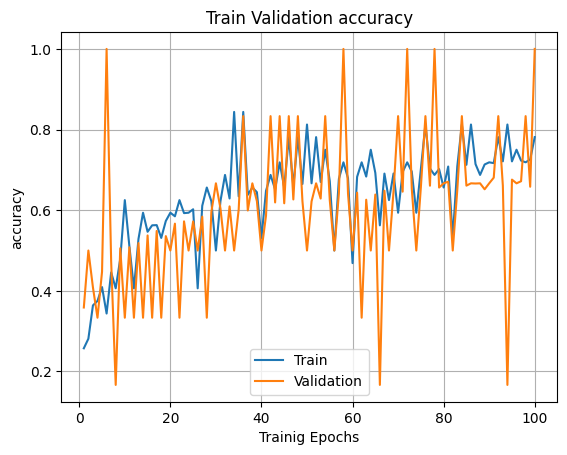

In [10]:
plot_history(history.history, False)

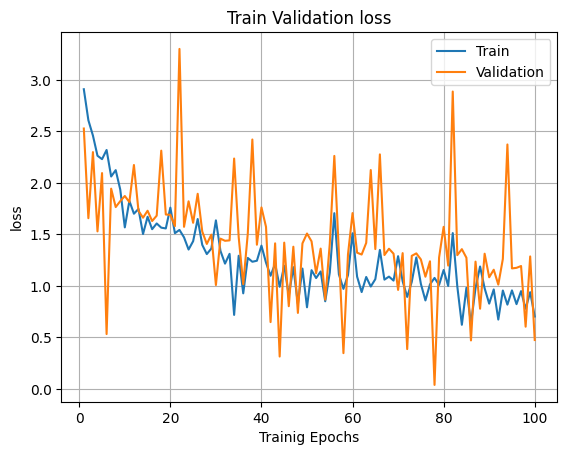

In [11]:
plot_history(history.history, True)